# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot
import seaborn as sns
import warnings
import itertools
warnings.filterwarnings("ignore")
%matplotlib inline

# Importing the csv file
Use Pandas to load input csv. Process the dataframe by dropping the unecessary columns.

In [2]:
df = pd.read_csv("data/bs140513_032310.csv")
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
df.drop(['step', 'age','gender','zipcodeOri','zipMerchant'], axis=1, inplace=True)
df.head()

,customer,merchant,category,amount,fraud
0,'C1093826151','M348934600','es_transportation',4.55,0
1,'C352968107','M348934600','es_transportation',39.68,0
2,'C2054744914','M1823072687','es_transportation',26.89,0
3,'C1760612790','M348934600','es_transportation',17.25,0
4,'C757503768','M348934600','es_transportation',35.72,0


# Loading Graph Json
Load the graph json file created using cypher query language on Neo4j graph, Extract useful features like degree, pagerank, etc. and append the data to the input dataframe object.

In [4]:
# Opening JSON file
f = open('data/graph_features.json')
data = json.load(f)

In [5]:
graph_features = {}
for d in data:
    graph_features[d['id']] = {'degree': d['degree'], 'pagerank': d['pagerank'], 'community': d['community']}

In [6]:
# Helper functions to add network features to input dataframe 
def addDegree(x):
    return graph_features[x]['degree']
def addCommunity(x):
    return str(graph_features[x]['community'])
def addPagerank(x):
    return graph_features[x]['pagerank']

In [7]:
df['custPageRank'] = df.customer.apply(addPagerank)
df['merchPageRank'] = df.merchant.apply(addPagerank)
df['merchDegree'] = df.merchant.apply(addDegree)
df['custDegree'] = df.customer.apply(addDegree)
df['merchCommunity'] = df.merchant.apply(addCommunity)
df['custCommunity'] = df.customer.apply(addCommunity)

In [8]:
df.head()

,customer,merchant,category,amount,fraud,custPageRank,merchPageRank,merchDegree,custDegree,merchCommunity,custCommunity
0,'C1093826151','M348934600','es_transportation',4.55,0,0.15,139.320182,11787,7,608498,608498
1,'C352968107','M348934600','es_transportation',39.68,0,0.15,139.320182,11787,12,608498,608498
2,'C2054744914','M1823072687','es_transportation',26.89,0,0.15,123.870722,10719,14,608499,608498
3,'C1760612790','M348934600','es_transportation',17.25,0,0.15,139.320182,11787,11,608498,608498
4,'C757503768','M348934600','es_transportation',35.72,0,0.15,139.320182,11787,14,608498,608498


## Extracting labels from dataframe

In [9]:
label = df.fraud

In [10]:
features_graph = df.drop('fraud', axis = 1)

## Scaling the attributes

In [11]:
scaler = MinMaxScaler()
df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']] = scaler.fit_transform(df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']])
features_graph[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']] = df[['amount', 'merchDegree', 'custDegree', 'custPageRank', 'merchPageRank']]

## One hot encoding of categorical features

In [12]:
final_features = pd.get_dummies(features_graph)

In [13]:
final_features.head()

,amount,custPageRank,merchPageRank,merchDegree,custDegree,customer_'C1000148617',customer_'C100045114',customer_'C1000699316',customer_'C1001065306',customer_'C1002658784',...,merchCommunity_608544,merchCommunity_608545,merchCommunity_608546,merchCommunity_608547,custCommunity_608498,custCommunity_608499,custCommunity_608500,custCommunity_608501,custCommunity_608504,custCommunity_608505
0,0.000546,0.0,1.000000,1.000000,0.172414,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.004764,0.0,1.000000,1.000000,0.344828,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.003228,0.0,0.888913,0.909322,0.413793,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.002071,0.0,1.000000,1.000000,0.310345,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.004288,0.0,1.000000,1.000000,0.413793,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Handling the class Imbalance Issue
Use RandomSampling and SMOTE to handle class imbalance.

In [14]:
print("counts of label '1': {}".format(sum(label == 1)))
print("counts of label '0': {} \n".format(sum(label == 0)))

counts of label '1': 7200
counts of label '0': 587443 



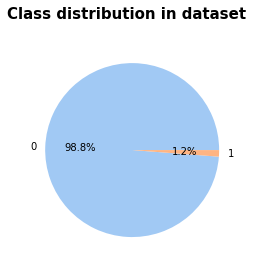

In [15]:
fig,ax=plt.subplots(1,1)
plt.pie(x=label.value_counts(),labels=["0","1"],colors=sns.color_palette('pastel'),autopct="%.1f%%")
fig.suptitle("Class distribution in dataset",y=1,fontweight="bold",fontsize=15)
plt.show()

In [16]:
under = RandomUnderSampler(0.03)
X_under, y_under = under.fit_resample(final_features, label)

In [17]:
sm = SMOTE(random_state=2, sampling_strategy=0.5)
features_resample, labels_resample = sm.fit_resample(X_under, y_under.ravel())

In [18]:
print("counts of label '1' after resampling: {}".format(sum(labels_resample == 1)))
print("counts of label '0' after resampling: {} \n".format(sum(labels_resample == 0)))

counts of label '1' after resampling: 120000
counts of label '0' after resampling: 240000 



In [19]:
labels_df = pd.Series(labels_resample) 

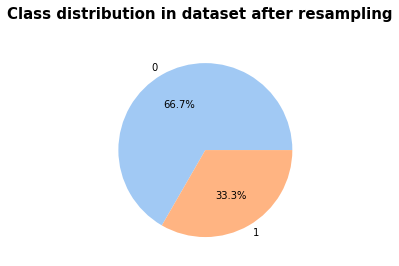

In [20]:
fig,ax=plt.subplots(1,1)
plt.pie(x=labels_df.value_counts(),labels=["0","1"],colors=sns.color_palette('pastel'),autopct="%.1f%%")
fig.suptitle("Class distribution in dataset after resampling",y=1,fontweight="bold",fontsize=15)
plt.show()

## Utility functions to plot confusion matrix and ROC

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
def plot_roc(predictions_prob, y_test_enh, ns_probs, model):
  lr_probs = predictions_prob[:, 1]
  ns_auc = roc_auc_score(y_test_enh, ns_probs)
  lr_auc = roc_auc_score(y_test_enh, lr_probs)
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print(model+': ROC AUC=%.3f' % (lr_auc))
  ns_fpr, ns_tpr, _ = roc_curve(y_test_enh, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test_enh, lr_probs)
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  pyplot.plot(lr_fpr, lr_tpr, marker='.', label=model)
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.legend()

## Instances for final testing of models

In [23]:
label_list = list(label)
test_data = df.iloc[[label_list.index(1)]] ## ground truth: fraud
test_data = test_data.append(df.iloc[[label_list.index(0)]]) ## ground truth: no fraud
test_data.head()

,customer,merchant,category,amount,fraud,custPageRank,merchPageRank,merchDegree,custDegree,merchCommunity,custCommunity
88,'C583110837','M480139044','es_health',0.005313,1,0.0,0.298948,0.336475,0.448276,608504,608498
0,'C1093826151','M348934600','es_transportation',0.000546,0,0.0,1.000000,1.000000,0.172414,608498,608498


In [24]:
## extracting features for test data

test_fraud = final_features.iloc[[label_list.index(1)]]
test_no_fraud = final_features.iloc[[label_list.index(0)]]
test_data = test_fraud.append(test_no_fraud)
test_data.head()

,amount,custPageRank,merchPageRank,merchDegree,custDegree,customer_'C1000148617',customer_'C100045114',customer_'C1000699316',customer_'C1001065306',customer_'C1002658784',...,merchCommunity_608544,merchCommunity_608545,merchCommunity_608546,merchCommunity_608547,custCommunity_608498,custCommunity_608499,custCommunity_608500,custCommunity_608501,custCommunity_608504,custCommunity_608505
88,0.005313,0.0,0.298948,0.336475,0.448276,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0,0.000546,0.0,1.000000,1.000000,0.172414,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Spliting data into train test sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features_resample, labels_resample, test_size = 0.3)

In [26]:
ns_probs = [0 for _ in range(len(y_test))]


# Model Training

We use three standard classification model: Random Forest, KNN and XGBoost for training on the extracted features. For evaluation we use training time, classification report, confusion matrix and ROC on the test data.

## Random Forest

In [27]:
%%time 
rf = RandomForestClassifier()
rf.fit(X_train, y_train.ravel())
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71993
           1       0.95      1.00      0.97     36007

    accuracy                           0.98    108000
   macro avg       0.97      0.99      0.98    108000
weighted avg       0.98      0.98      0.98    108000

Wall time: 4min 35s


**confusion matrix for test data using random forest**

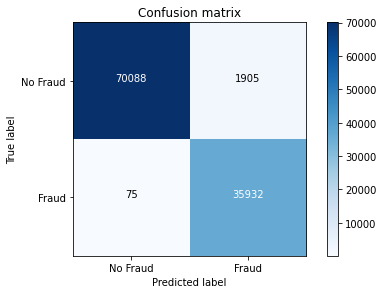

In [28]:
cnf_matrix_tra = confusion_matrix(y_test, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.998


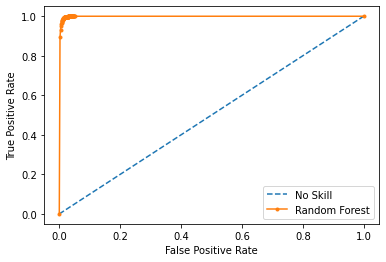

In [29]:
predictions_prob = rf.predict_proba(X_test)
plot_roc(predictions_prob, y_test, ns_probs, 'Random Forest')
pyplot.show()

## KNN

In [30]:
%%time 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train.ravel())
predictions = knn.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     71993
           1       0.91      1.00      0.95     36007

    accuracy                           0.97    108000
   macro avg       0.96      0.98      0.96    108000
weighted avg       0.97      0.97      0.97    108000

Wall time: 29min 13s


**confusion matrix for test data using KNN**

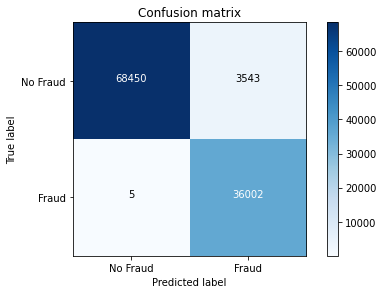

In [31]:
cnf_matrix_tra = confusion_matrix(y_test, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.983


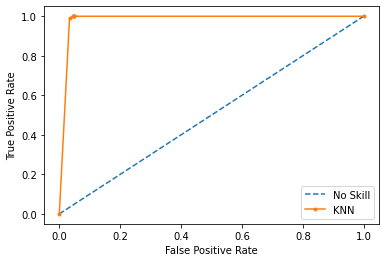

In [32]:
predictions_prob = knn.predict_proba(X_test)
plot_roc(predictions_prob, y_test, ns_probs, 'KNN')
pyplot.show()

## XGBoost

In [33]:
%%time 
xgb = XGBClassifier()
xgb.fit(X_train, y_train.ravel())
predictions = xgb.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     71993
           1       0.97      0.99      0.98     36007

    accuracy                           0.99    108000
   macro avg       0.98      0.99      0.98    108000
weighted avg       0.99      0.99      0.99    108000

Wall time: 7min 34s


**confusion matrix for test data using XGBoost**

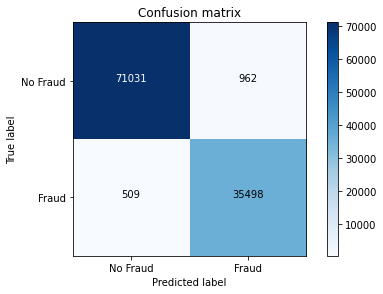

In [34]:
cnf_matrix_tra = confusion_matrix(y_test, predictions)
class_names = ['No Fraud', 'Fraud']
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.999


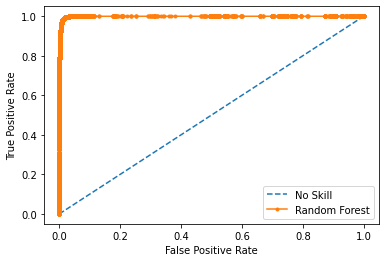

In [35]:
predictions_prob = xgb.predict_proba(X_test)
plot_roc(predictions_prob, y_test, ns_probs, 'Random Forest')
pyplot.show()

# Testing the models
testing the model with one fraud and one non fraud instance

In [36]:
## testing using different models. 0-->no fraud  1-->fraud

predicted_results = {}
predicted_results['random forest'] = rf.predict(test_data)
predicted_results['KNN'] = knn.predict(test_data)
predicted_results['XGBoost'] = xgb.predict(test_data)

print(predicted_results)

{'random forest': array([1, 0], dtype=int64), 'KNN': array([1, 0], dtype=int64), 'XGBoost': array([1, 0])}
